In [1]:
from sklearn.datasets import make_classification  #  Dummy data
from sklearn.calibration import CalibratedClassifierCV  #  Performs Calibration
from sklearn.calibration import calibration_curve  # Visualise calibration
from sklearn.model_selection import train_test_split  # Split in train set
from sklearn.linear_model import LogisticRegression  # Main model for dummy data
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve  # score of model and determine how well calibration is via number
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

<h3>Case 1: Unbalanced Dataset</h3>

In [2]:
df = pd.read_pickle(r'specify_path_to_file')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

Xs = df.drop(['CONTRACT_REF_NO_raw', 'bad_flag', 'public1_score', 'tr_score', 'eom1_score'], axis=1)
ys = pd.DataFrame(df['bad_flag'])
ys.rename(columns={'bad_flag': 'label'}, inplace=True)

In [4]:
# splits data into 10% test and 90% train x 2
# train set to train model
# val set to calibrate model
# test set to test model
X_train_raw, X_test, y_train_raw, y_test = train_test_split(Xs, ys, test_size=0.30, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.30, shuffle=False)

print(f"Len initial sample     {len(Xs)}")
print(f"Len training sample    {len(X_train)}")
print(f"Len calibration sample {len(X_val)}")
print(f"Len testing sample     {len(X_test)}\n")

Len initial sample     206611
Len training sample    101238
Len calibration sample 43389
Len testing sample     61984



<h3>2.1 Uncalibrated Model</h3>

In [5]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict_proba(X_test)[:, 1]

In [6]:
roc_auc_score(y_test, y_pred)

0.8338597109543373

In [7]:
brier_score_loss(y_test, y_pred)

0.15544444672696175

<p>This is a way of calculating accuracy in the model<br>Accuracy = number of correct predictions / number of predictions</p>

In [8]:
clf.score(X_test, y_test)

0.819776071244192

<p>Create a list of no-score probability for y=x line on chart</p>

In [9]:
ns_probs = [0 for n in range(len(y_test))]

<p>ROC (Receiver Operating Characteristic) curve chart<br>Plots true positive rate (sensitivity) against false positive rate (fall-out)</p>

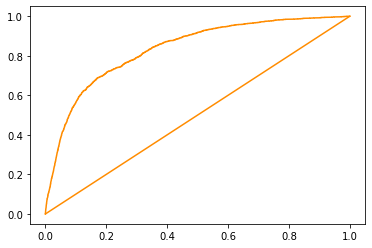

In [10]:
fallout, sensitivity, thresholds = roc_curve(y_test, y_pred)
f, s, t = roc_curve(y_test, ns_probs)
plt.plot(fallout, sensitivity, f, s, color = 'darkorange')

In [11]:
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'])
pred_df = pd.concat([y_pred_df, y_test.reset_index()], axis=1)[['prediction', 'label']]

In [12]:
y_pred_df.describe()

,prediction
count,61984.000000
mean,0.352714
std,0.202234
min,0.123246
25%,0.208652
50%,0.263243
75%,0.451399
max,0.998859


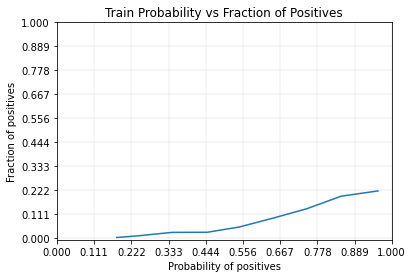

In [13]:
plt.rcParams.update({'font.size': 10})
frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
sns.lineplot(x=pred_prob, y=frac_of_positives)
plt.grid(linestyle='-', linewidth=0.2)
plt.title("Train Probability vs Fraction of Positives")
xlabel = plt.xlabel("Probability of positives")
ylabel = plt.ylabel("Fraction of positives")
ticks = np.linspace(0, 1, 10)
xticks = plt.xticks(ticks)
yticks = plt.yticks(ticks)

<h3>2.2 Calibrated Model (prefit)</h3>

In [16]:
calibrated_clf = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
calibrated_clf.fit(X_val, y_val)
y_pred = calibrated_clf.predict_proba(X_test)[:, 1]

C:\Users\mkim414\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [17]:
roc_auc_score(y_test, y_pred)

0.8331205609374434

In [18]:
brier_score_loss(y_test, y_pred)

0.028936745257407654

<p>This is a way of calculating accuracy in the model<br>Accuracy = number of correct predictions / number of predictions</p>

In [19]:
calibrated_clf.score(X_test, y_test)

0.9672980123902942

<p>Create a list of no-score probability for y=x line on chart</p>

In [20]:
ns_probs = [0 for n in range(len(y_test))]

<p>ROC (Receiver Operating Characteristic) curve chart<br>Plots true positive rate (sensitivity) against false positive rate (fall-out)</p>

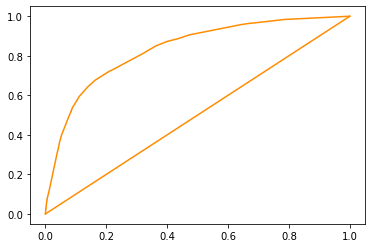

In [21]:
fallout, sensitivity, thresholds = roc_curve(y_test, y_pred)
f, s, t = roc_curve(y_test, ns_probs)
plt.plot(fallout, sensitivity, f, s, color = 'darkorange')

In [22]:
y_pred_df = pd.DataFrame(y_pred, columns=['prediction'])
pred_df = pd.concat([y_pred_df, y_test.reset_index()], axis=1)[['prediction', 'label']]

In [23]:
y_pred_df.describe()

,prediction
count,61984.000000
mean,0.033008
std,0.054185
min,0.000000
25%,0.005221
50%,0.008912
75%,0.027908
max,0.428571


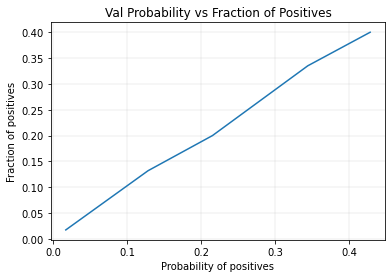

In [24]:
plt.rcParams.update({'font.size': 10})
frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
sns.lineplot(x=pred_prob, y=frac_of_positives)
plt.grid(linestyle='-', linewidth=0.2)
plt.title("Val Probability vs Fraction of Positives")
xlabel = plt.xlabel("Probability of positives")
ylabel = plt.ylabel("Fraction of positives")